# Imports and configuring a reproducibility seed

In [1]:
import os

import numpy as np
import random
import tensorflow as tf

seed = 1729959202

np.random.seed(seed)

random.seed(seed)

tf.random.set_seed(seed)

import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, roc_curve, auc
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


2024-10-27 13:40:47.682732: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1730032847.691368     736 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1730032847.693973     736 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-27 13:40:47.703351: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Read data from I/O

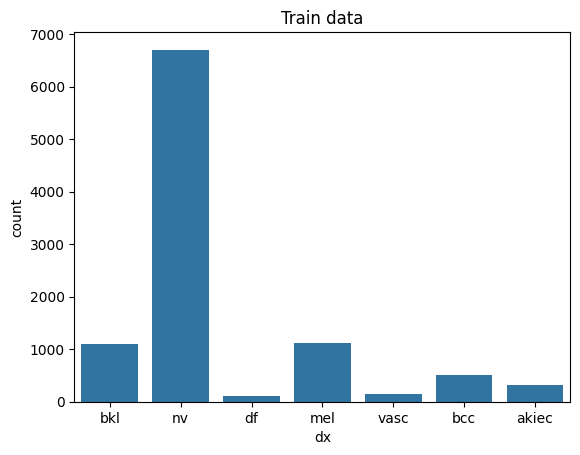

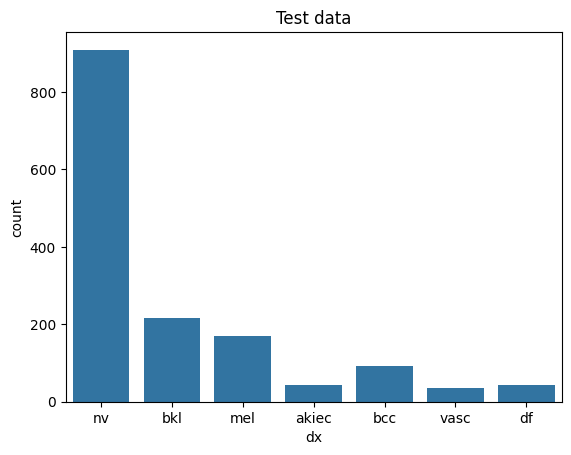

In [3]:
data_path = 'data/ham10000/HAM10000_metadata.csv'
df = pd.read_csv(data_path)

image_dir = 'data/ham10000/images/'  
test_image_dir = 'data/ham10000/images/test_images/'

df['image_path'] = image_dir + df['image_id'] + '.jpg'

df.head()

label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['dx'])

sns.countplot(x='dx', data=df)
plt.title('Train data')
plt.show()

test_data_path = 'data/ham10000/images/ISIC2018_Task3_Test_GroundTruth.csv'

test_df = pd.read_csv(test_data_path)
test_df['image_path'] = test_image_dir + test_df['image_id'] + '.jpg'
test_df['label'] = label_encoder.transform(test_df['dx'])

sns.countplot(x='dx', data=test_df)
plt.title('Test data')
plt.show()

train_df, val_df = train_test_split(df, test_size=0.1, stratify=df['label'], random_state=42)

# Check for data leaks

In [4]:
train_set = set(train_df['image_path'])
val_set = set(val_df['image_path'])
test_set = set(test_df['image_path'])

print("Overlaps between train and validation:", train_set.intersection(val_set))
print("Overlaps between train and test:", train_set.intersection(test_set))
print("Overlaps between validation and test:", val_set.intersection(test_set))

Overlaps between train and validation: set()
Overlaps between train and test: set()
Overlaps between validation and test: set()


# Convert label to string for API compatibility

In [5]:
train_df['label'] = train_df['label'].astype(str)
val_df['label'] = val_df['label'].astype(str)
test_df['label'] = test_df['label'].astype(str)

# Load and Augment Images and create tf.Data.Dataset instances for all parts of the data

In [6]:
image_size = (128, 128)
batch_size = 128
num_classes = len(df['dx'].unique())
img_height, img_width = image_size

def load_and_preprocess_image(image_path, label, augment=False):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [img_height, img_width]) / 255.0  

    if augment:
        img = tf.image.rot90(img, k=tf.random.uniform([], 0, 4, dtype=tf.int32))  
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_brightness(img, max_delta=0.2)

    return img, label

def create_dataset(df, augment=False, batch_size=32):
    df = df[df['image_path'].apply(os.path.exists)]
    
    image_paths = df['image_path'].values
    labels = df['label'].values
    labels = tf.keras.utils.to_categorical(labels, num_classes)

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))

    def preprocess_with_augment(image_path, label):
        return load_and_preprocess_image(image_path, label, augment)

    dataset = dataset.map(preprocess_with_augment, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

    return dataset

train_dataset = create_dataset(train_df, augment=True, batch_size=batch_size)
val_dataset = create_dataset(val_df, batch_size=batch_size)
test_dataset = create_dataset(test_df, batch_size=batch_size)


I0000 00:00:1730032850.194727     736 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5564 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:09:00.0, compute capability: 8.6


In [7]:
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout



def build_model(hp):
    # Define hyperparameters
    conv_1_filters = hp.Int('conv_1_filters', min_value=32, max_value=256, step=32)
    conv_2_filters = hp.Int('conv_2_filters', min_value=32, max_value=128, step=32)
    conv_3_filters = hp.Int('conv_3_filters', min_value=32, max_value=64, step=16)
    dense_units = hp.Int('dense_units', min_value=64, max_value=256, step=64)
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')
    activation = hp.Choice('activation', values=['relu', 'tanh', 'sigmoid'])


    # Build the model
    model = Sequential()
    input_shape = (128, 128, 3)
    model.add(Input(input_shape))
    model.add(Conv2D(
        filters=conv_1_filters,
        kernel_size=(2,2),
        activation=activation))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(
        filters=conv_2_filters,
        kernel_size=(2,2),
        activation=activation))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(
        filters=conv_3_filters,
        kernel_size=(2,2),
        activation=activation))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(
        units=dense_units,
        activation=activation))
    model.add(Dropout(0.5))
    model.add(Dense(7, activation='softmax')) 

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy'])
    
    return model

tuner = kt.BayesianOptimization(
    build_model,
    objective='val_accuracy',
    max_trials=20, 
    directory='first_hyperparameter_search',
    project_name='cnn_bayesian_search',
    seed=seed)

In [8]:
tuner.search(
    train_dataset,
    epochs=20,
    validation_data=val_dataset)

Trial 2 Complete [00h 00m 13s]

Best val_accuracy So Far: None
Total elapsed time: 00h 00m 33s

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
160               |256               |conv_1_filters
64                |96                |conv_2_filters
48                |32                |conv_3_filters
64                |128               |dense_units
0.0025314         |0.0019884         |learning_rate
sigmoid           |relu              |activation

Epoch 1/20


2024-10-27 13:41:30.446992: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:378] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.


KeyboardInterrupt: 